In [1]:
import warnings
warnings.simplefilter('ignore')

# Molecular Dynamics

In this tutorial we will cover how to use trained models to drive MD simulations.
For this purpose, apax offers two options: ASE and JaxMD. Keep in mind that JaxMD can be GPU/TPU accelerated and is therefore much faster.
Both will be covered below.

## Basic Model Training

First we need to train a model.
If you have the parameters from tutorial 01, you can point the paths to those models and skip the current section to the [ASE MD](##-The-ASE-calculator) or the [JaxMD](##-JaxMD) section.

In [2]:
!apax template train    # generating the config file in the cwd

In [3]:
from pathlib import Path
from apax.utils.datasets import download_etoh_ccsdt, mod_md_datasets
from apax.train.run import run
from apax.utils.helpers import mod_config
import yaml


# Download and modify the dataset
data_path = Path("project")
experiment = "etoh_md"


train_file_path, test_file_path = download_etoh_ccsdt(data_path)
train_file_path = mod_md_datasets(train_file_path)
test_file_path = mod_md_datasets(test_file_path)


# Modify the config file (can be done manually)
config_path = Path("config.yaml")

config_updates = {
    "n_epochs": 100,
    "data": {
        "n_train": 990,
        "n_valid": 10,
        "valid_batch_size": 1,
        "experiment": experiment,
        "directory": "project/models",
        "data_path": str(train_file_path),
        "test_data_path": str(test_file_path),
        "energy_unit": "kcal/mol",
        "pos_unit": "Ang",
    },
    "model": {
        "descriptor_dtype": "fp64"
    },
}
config_dict = mod_config(config_path, config_updates)
with open("config.yaml", "w") as conf:
    yaml.dump(config_dict, conf, default_flow_style=False)

# Train model
run(config_dict)


2024-03-13 13:23:46.912545: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.4 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
Epochs: 100%|████████████████████████████████████| 100/100 [00:47<00:00,  2.10it/s, val_loss=0.0693]


## The ASE calculator

If you require some ASE features during your simulation, we provide an alternative to the JaxMD interface.

Please refer to the [ASE documentation](https://wiki.fysik.dtu.dk/ase/ase/calculators/calculators.html)  to see how to use ASE calculators.

An ASE calculator of a trained model can be instantiated as follows. Subsequend a ASE-MD is performed and OH-bondlength distribution is analysed.

In [4]:
from ase.io import read
from apax.md import ASECalculator
from ase.md.langevin import Langevin
from ase import units
from ase.io.trajectory import Trajectory


# read starting structure and define modelpath
atoms = read(train_file_path, index=0)
model_dir = data_path / f"models/{experiment}"


# initiolize the apax ase calculator and assign it to the starting structure
calc = ASECalculator(model_dir=model_dir)
atoms.calc = calc

# perform MD simulation
dyn = Langevin(
    atoms=atoms,
    timestep=0.5 * units.fs,
    temperature_K=300,
    friction=0.01 / units.fs,
)

traj = Trajectory('example.traj', 'w', atoms)
dyn.attach(traj.write, interval=1)
dyn.run(10000)
traj.close()

<a id='bondlength'></a>

In [5]:
import matplotlib.pyplot as plt
import numpy as np

def plot_bondlength_distribution(traj, indices: list, bins: int=25):
    oh_dist = []
    for atoms in traj:
        oh_dist.append(atoms.get_distances(indices[0], indices[1]))

    fig, axs = plt.subplots()
    axs.hist(np.array(oh_dist), bins=25)
    fig.show()

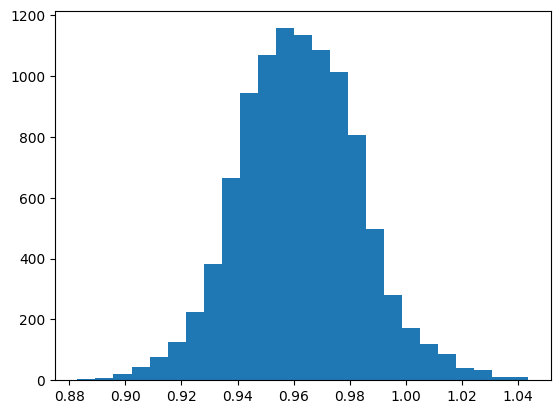

In [6]:
# plot OH bondlength distribution of the MLMD simulation
traj = Trajectory('example.traj')
plot_bondlength_distribution(traj, indices=[2, -1])


## JaxMD

While the ASE interface is convenient and flexible, it is not meant for high performance applications.
For these purposes, apax comes with an interface to [JaxMD](https://jax-md.readthedocs.io/en/main/#).
JaxMD is a high performance molecular dynamics engine built on top of [Jax](https://jax.readthedocs.io/en/latest/index.html).
The CLI provides easy access to standard NVT and NPT simulations.
More complex simulation loops are relatively easy to build yourself in JaxMD (see their colab notebooks for examples). 
Trained apax models can of course be used as `energy_fn` in such custom simulations.
If you have a suggestion for adding some MD feature or thermostat to the core of `apax`, feel free to open up an issue on [Github]{https://github.com/apax-hub/apax}.


### Configuration
We can once again use the template command to give ourselves a quickstart.


In [7]:
!apax template md


Open the config and specify the starting structure and simulation parameters.
If you specify the data set file itself, the first structure of the data set is going to be used as the initial structure.
Your `md_config_minimal.yaml` should look similar to this:

```yaml
ensemble:
    temperature: 300 # K
    
duration: 20_000 # fs
initial_structure: project/benzene_mod.xyz
```


In [27]:
from apax.utils.helpers import mod_config
import yaml


md_config_path = Path("md_config.yaml")

config_updates = {
    "initial_structure": str(train_file_path),    # if the model from example 01 is used change this
    "duration": 5000, #fs
    "ensemble": {
        "temperature": 300,
    }
}
config_dict = mod_config(md_config_path, config_updates)

with open(md_config_path, "w") as conf:
    yaml.dump(config_dict, conf, default_flow_style=False)


As with training configurations, we can use the `validate` command to ensure our input is valid before we submit the calculation.


In [9]:
!apax validate md md_config.yaml

Success!
md_config.yaml is a valid MD config.


## Running the simulation

The simulation can be started by running where `config.yaml` is the configuration file that was used to train the model.

In [28]:
!apax md config.yaml md_config.yaml


INFO | 13:39:53 | reading structure
INFO | 13:39:53 | Unable to initialize backend 'rocm': NOT_FOUND: Could not find registered platform with name: "rocm". Available platform names are: CUDA
INFO | 13:39:53 | Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory
2024-03-13 13:39:54.071387: W external/xla/xla/service/gpu/nvptx_compiler.cc:742] The NVIDIA driver's CUDA version is 11.4 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.
INFO | 13:39:54 | initializing model
INFO | 13:39:54 | loading checkpoint from /home/linux3_i1/segreto/uni/dev/apax/examples/project/models/etoh_md/best
INFO | 13:39:54 | Initializing new trajectory file at md/md.h5
INFO | 13:39:54 | initializing s

During the simulation, a progress bar tracks the instantaneous temperature at each outer step.
The simulation is followd by a small oh bondlength distribution analyses of the trajectory defined [here](#bondlength).

[6 6 8 1 1 1 1 1 1]


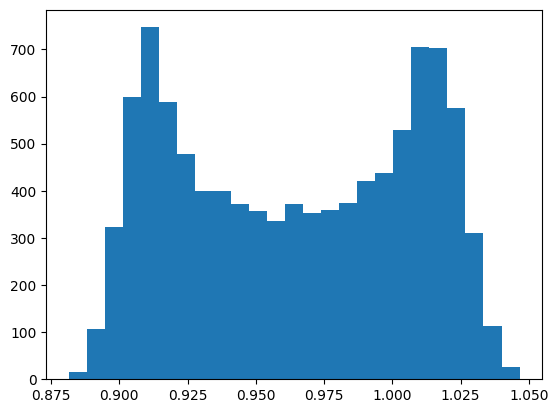

In [29]:
import znh5md

atoms = znh5md.ASEH5MD("md/md.h5").get_atoms_list()
print(atoms[0].numbers)
plot_bondlength_distribution(atoms, indices=[2, -1])

To remove all the created files and clean up yor working directory run

In [12]:
# !rm -rf project md config.yaml example.traj md_config.yaml